In [1]:
import os
print('Conda environment:', os.environ['CONDA_DEFAULT_ENV'])

Conda environment: py3613


## Attached to UNIONS : The impact of systematic errors on weak-lensing peak counts

In [2]:
import numpy as np
import emcee
import numpy.linalg as la
import matplotlib.pyplot as plt
from getdist import plots, MCSamples, parampriors
from joblib import Parallel, delayed, cpu_count
from multiprocessing import cpu_count, Pool
import time
from chainconsumer import ChainConsumer
from utils import *
from likelihood import *
import os
import sys

In [3]:
#for tex in ChainConsumer
pref = os.environ['CONDA_PREFIX']
os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin'

### Specify the free parameters for redshift, shear calibration, baryonic correction and cut in S/N

In [4]:
# Check the README to know the possibility for the different cases and reproduce the plots
param_z = '065' 
param_z_cov = '0.65'
param_cal = 'dm_1deg'
param_baryonic_correction = 'Fid'
param_cut = 19
n_patches = 13

### Load the file names for peaks file 

In [5]:
file_name_peaks_Maps = (np.array(np.loadtxt('.././input/list_cosmo_peaks_z{}.txt'.format(param_z), usecols=0,dtype=str)))

### Extract cosmological parameters values from the simulations associated to each peak counts file

In [6]:
params = np.array([takes_params(f) for f in file_name_peaks_Maps])

In [7]:
#identifies fiducial cosmology index
index_fiducial = 15
params_fiducial = params[index_fiducial]

In [8]:
params_fiducial

array([0.1, 0.3, 2.1])

In [9]:
np.save('../saves_from_py3613/params', params)
np.save('../saves_from_py3613/params_fiducial', params_fiducial)

### Download peaks distribution for theoretical prediction

In [13]:
#create the folder where to store the peaks distribution from the simulation
!mkdir \\wsl.localhost\Ubuntu-20.04\home\andreas\work\shear-pipe-peaks\shear-pipe-peaks\input\peaks_z065

In [15]:
# #create the folder where to store the peaks distribution from the simulation
# !mkdir /home/andreas/work/shear-pipe-peaks/shear-pipe-peaks/input/peaks_z065_py3613

#### !!! Before evaluating the next cell, do the following: 


- Download the peaks distribution for the theoretical prediction from [here](https://zenodo.org/record/6344515#.Yk2j6S0QOqA) with the following command on your terminal:

  *zenodo_get 10.5281/zenodo.6344515*
 
 this will download 238 MB on your local machine


- Store them in the folder **peaks_z065/** that you can find in the **input/** folder



In [10]:
#load the peaks distributions for the theoretical prediction
Peaks_Maps_DM = np.array([np.load('../input/peaks_z{}/%s'.format(param_z)%(fn), mmap_mode='r') for fn in file_name_peaks_Maps])[:,:,:param_cut]

In [11]:
#these are shaped as (#cosmologies, #realisations, #bins)
print(np.shape(Peaks_Maps_DM))

(99, 10000, 19)


### Load the different baryonic corrections

In [12]:
bar_corr = np.load('.././input/{}_correction.npy'.format(param_baryonic_correction))[:param_cut]

### Apply the baryonic correction

In [13]:
Peaks_Maps = np.copy(Peaks_Maps_DM)

if(param_baryonic_correction == 'no'):
    # no baryonic correction
    for i in range(Peaks_Maps_DM.shape[0]):
        for j in range(Peaks_Maps_DM.shape[1]):
            Peaks_Maps[i,j,:] = Peaks_Maps_DM[i,j,:] * 1
else:
    # apply the choosen baryonic correction
    for i in range(Peaks_Maps_DM.shape[0]):
        for j in range(Peaks_Maps_DM.shape[1]):
            Peaks_Maps[i,j,:] = Peaks_Maps_DM[i,j,:] * bar_corr
        
print(np.shape(Peaks_Maps))

(99, 10000, 19)


In [14]:
Peaks_Maps_mean=np.mean(Peaks_Maps, axis=1)

In [15]:
Peaks_Maps_mean.shape

(99, 19)

In [16]:
snr_array=np.linspace(-2,6,31)

In [17]:
snr_centers=0.5*(snr_array[1:]+snr_array[:-1])

In [18]:
np.save('../saves_from_py3613/Peaks_Maps', Peaks_Maps)
np.save('../saves_from_py3613/Peaks_Maps_mean', Peaks_Maps_mean)
np.save('../saves_from_py3613/snr_array', snr_array)
np.save('../saves_from_py3613/snr_centers', snr_centers)

### Load peaks distribution for data

In [19]:
peaks_data = np.load('.././input/peaks_mean_{}.npy'.format(param_cal), mmap_mode='r')[:param_cut]

### Train Gaussian Processes regressor

In [20]:
#this returns a tuple consisting of (list of GP, scaling)
ncpu = cpu_count()
gp_scaling=np.array([Parallel(n_jobs = 1, verbose = 5)(delayed(gp_train)(index_bin, params_train = params, obs_train = Peaks_Maps) for index_bin in range(Peaks_Maps.shape[2]))]).reshape(Peaks_Maps.shape[2], 2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   14.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   18.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:  1.6min finished


In [21]:
gp_scaling.shape

(19, 2)

In [22]:
gp_list=gp_scaling[:,0]
scaling=gp_scaling[:,1]

In [23]:
test = GP_pred(params_fiducial,gp_list,scaling)

In [24]:
np.save('../saves_from_py3613/peaks_data', peaks_data)
np.save('../saves_from_py3613/gp_scaling', gp_scaling)
np.save('../saves_from_py3613/gp_list', gp_list)
np.save('../saves_from_py3613/scaling', scaling)
np.save('../saves_from_py3613/test', test)

## Covariance matrix

#### Load peaks to compute covariance matrix

In [28]:
cov_peaks_DM = np.load('.././input/convergence_gal_mnv0.00000_om0.30000_As2.1000_peaks_2arcmin_{}_b030_snr_min_max_ngal_7.npy'.format(param_z_cov), mmap_mode='r')[:,:param_cut]

In [29]:
print(np.shape(cov_peaks_DM))

(10000, 19)


#### Apply the baryonic correction

In [30]:
cov_peaks = np.copy(cov_peaks_DM)
for i in range(Peaks_Maps_DM.shape[1]):
    cov_peaks[i,:] = cov_peaks_DM[i,:] * bar_corr

print(np.shape(cov_peaks))

(10000, 19)


#### Compute covariance matrix and scale it for sky coverage

In [31]:
cov=(1/n_patches)*np.cov(cov_peaks.T)

#### Plot correlation matrix

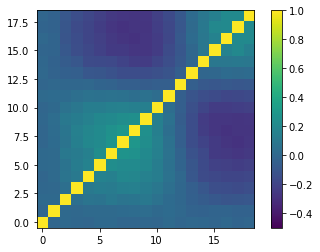

In [32]:
corr=np.corrcoef(cov_peaks.T)

plt.imshow(corr, origin='lower', vmin=-0.5,vmax=1)
plt.colorbar()

In [33]:
#compute the inverse of the covariance
icov=la.inv(cov)

In [34]:
print(np.shape(icov))

(19, 19)


### Get constraints with MCMC

#### Compute the Hartlap factor

In [1]:
n_real=Peaks_Maps_DM.shape[1]
n_bins=len(peaks_data)
norm=(n_real-n_bins-2)/(n_real-1)
print(norm)

NameError: name 'Peaks_Maps_DM' is not defined

#### Define values for the prior for the parameters

In [36]:
M_nu_min = 0.06  # minimum from oscillation experiments
M_nu_max = 0.62
Omega_m_min = 0.18
Omega_m_max = 0.42
A_s_min = 1.29
A_s_max = 2.91

#### Specify number of dimensions for parameter space, number of walkers, initial position

In [37]:
ndim, nwalkers = 3,250
pos = [params_fiducial +  1e-3*np.random.randn(ndim) for i in range(nwalkers)]

#### Run MCMC

In [38]:
print("{0} CPUs".format(ncpu))


with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnpost, pool=pool, args=[peaks_data, icov,gp_list, scaling, norm,M_nu_min, M_nu_max, Omega_m_min, Omega_m_max, A_s_min, A_s_max])
    start = time.time()
    sampler.run_mcmc(pos, 6500, progress=True)
    end = time.time()
    multi_time = end - start
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))

samples = sampler.chain[:,200:, :].reshape((-1, ndim))

8 CPUs


100%|██████████| 6500/6500 [1:26:01<00:00,  1.26it/s]


Multiprocessing took 5180.2 seconds


In [78]:
np.save('.././output/constraints_z{}_{}_{}corr_{}snr.npy'.format(param_z,param_cal,param_baryonic_correction,param_cut),samples)

In [79]:
samples = MCSamples(samples=samples,names = [r"$M_{\nu}[eV]$","$\Omega_m$", r"$A_s$"], 
                                ranges={r"$M_{\nu}[eV]$":[0.06,0.6],"$\Omega_m$":[0.18,0.42], r"$A_s$":[1.29, 2.91]})

Removed no burn in


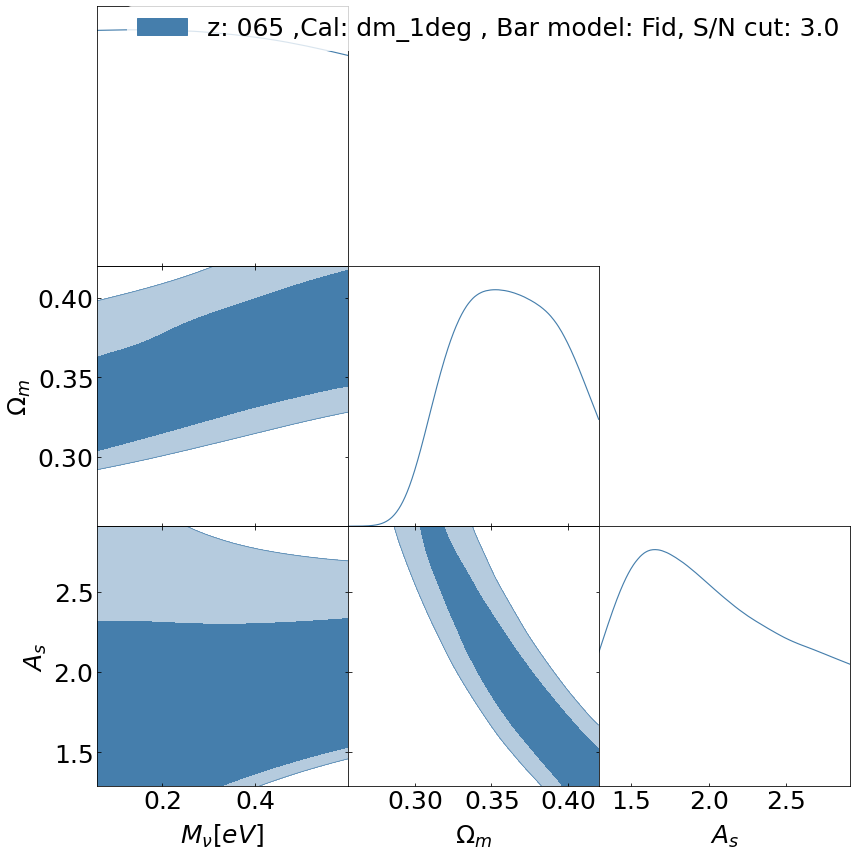

In [80]:
g = plots.get_subplot_plotter(width_inch=12)
g.settings.legend_fontsize = 25
g.settings.axes_fontsize = 25
g.settings.axes_labelsize = 25
g.settings.alpha_factor_contour_lines = 1
g.settings.figure_legend_frame = False
g.triangle_plot([samples],filled=True,
                legend_labels=['z: {} ,Cal: {} , Bar model: {}, S/N cut: {}'.format(param_z, param_cal, param_baryonic_correction, np.round(snr_centers[param_cut]), 1)],
               contour_colors=['#457EAC'])

### Load the output

#### For every figure

In [81]:
constraints_global = np.load('.././output/constraints_z065_global_nocorr_30snr.npy')

#### Fig. 7 and Fig. 8

In [82]:
constraints_05deg = np.load('.././output/constraints_z065_05deg_nocorr_30snr.npy')
constraints_1deg = np.load('.././output/constraints_z065_1deg_nocorr_30snr.npy')
constraints_2deg = np.load('.././output/constraints_z065_2deg_nocorr_30snr.npy')
constraints_4deg = np.load('.././output/constraints_z065_4deg_nocorr_30snr.npy')
constraints_dm_1deg = np.load('.././output/constraints_z065_dm_1deg_nocorr_30snr.npy')

#### Fig. 9

In [83]:
constraints_z068 = np.load('.././output/constraints_z068_global_nocorr_30snr.npy')

#### Fig. 11

In [84]:
constraints_fidcorr = np.load('.././output/constraints_z065_global_Fidcorr_30snr.npy')
constraints_LowAGNcorr = np.load('.././output/constraints_z065_global_LowAGNcorr_30snr.npy')
constraints_HighAGNcorr = np.load('.././output/constraints_z065_global_HighAGNcorr_30snr.npy')

#### Fig. 12

In [85]:
constraints_cutsnr = np.load('.././output/constraints_z065_global_nocorr_19snr.npy')

#### Fig. 13

In [86]:
constraints_cons_model = np.load('.././output/constraints_z065_dm_1deg_Fidcorr_19snr.npy')

## Plotting example 

In [87]:
# Example for fig 13
samples_global = MCSamples(samples=constraints_global, names=[r"$M_{\nu}[eV]$","$\Omega_m$", r"$A_s$"], 
                                ranges={r"$M_{\nu}[eV]$":[0.06,0.6],"$\Omega_m$":[0.18,0.42], r"$A_s$":[1.29, 2.91]})

samples_cons_model = MCSamples(samples=constraints_cons_model,names = [r"$M_{\nu}[eV]$","$\Omega_m$", r"$A_s$"], 
                                ranges={r"$M_{\nu}[eV]$":[0.06,0.6],"$\Omega_m$":[0.18,0.42], r"$A_s$":[1.29, 2.91]})

Removed no burn in
Removed no burn in


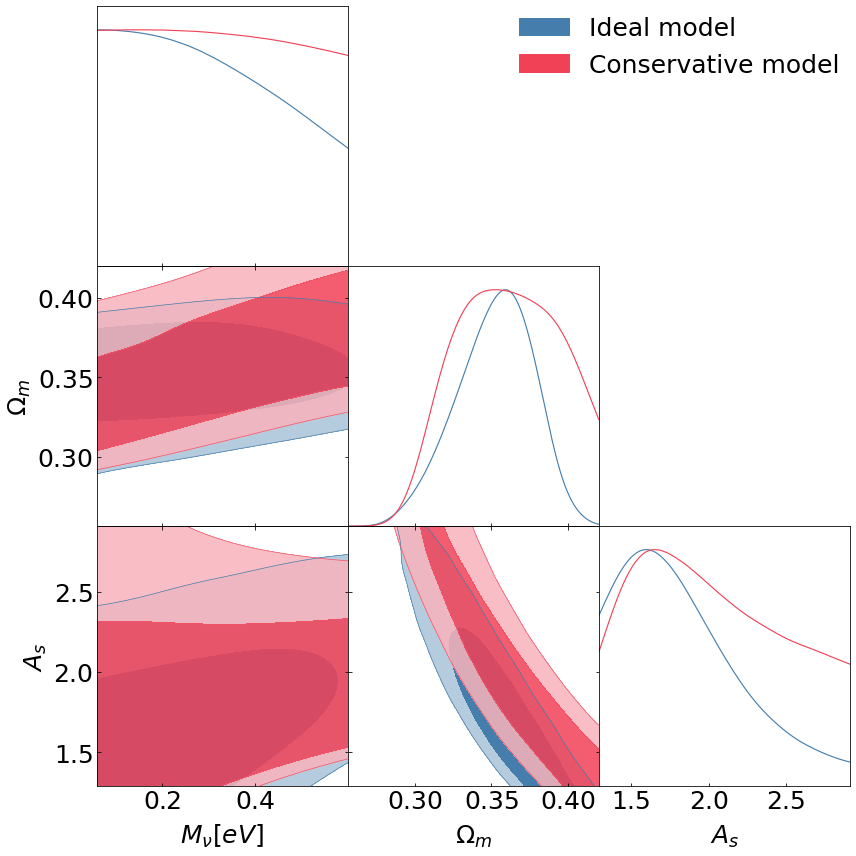

In [88]:
g = plots.get_subplot_plotter(width_inch=12)
g.settings.legend_fontsize = 25
g.settings.axes_fontsize = 25
g.settings.axes_labelsize = 25
g.settings.alpha_factor_contour_lines = 1
g.settings.figure_legend_frame = False
g.triangle_plot([samples_global,samples_cons_model],filled=True,
                legend_labels=['Ideal model', 'Conservative model'],
               contour_colors=['#457EAC','#F14156'])
plt.savefig('.././plot/constraints_ideal_conservative.png')

#### Fig. 14

In [103]:
# Fig 14: marginalised error bars
def get_instance():
    c = ChainConsumer()
    parameters = ["sum Mnu [eV]","Omega_m", "A_s"]
    c.add_chain(constraints_global, parameters=parameters, name='Ideal model')
    c.add_chain(constraints_05deg, parameters=parameters, name='0.5° calibration')
    c.add_chain(constraints_1deg, parameters=parameters, name='1° calibration')
    c.add_chain(constraints_dm_1deg, parameters=parameters, name='1° calibration, $\Delta m = 0.007$')
    c.add_chain(constraints_2deg, parameters=parameters, name='2° calibration')
    c.add_chain(constraints_4deg, parameters=parameters, name='4° calibration')
    c.add_chain(constraints_z068, parameters=parameters, name='z = 0.68')
    c.add_chain(constraints_cutsnr, parameters=parameters, name='$-2 <$ SNR $< 3$')
    c.add_chain(constraints_LowAGNcorr, parameters=parameters, name='LowAGN baryonic correction')
    c.add_chain(constraints_fidcorr, parameters=parameters, name='Fiducial baryonic correction')
    c.add_chain(constraints_HighAGNcorr, parameters=parameters, name='HighAGN baryonic correction')
    c.add_chain(constraints_cons_model, parameters=parameters, name='Conservative model')
    return c

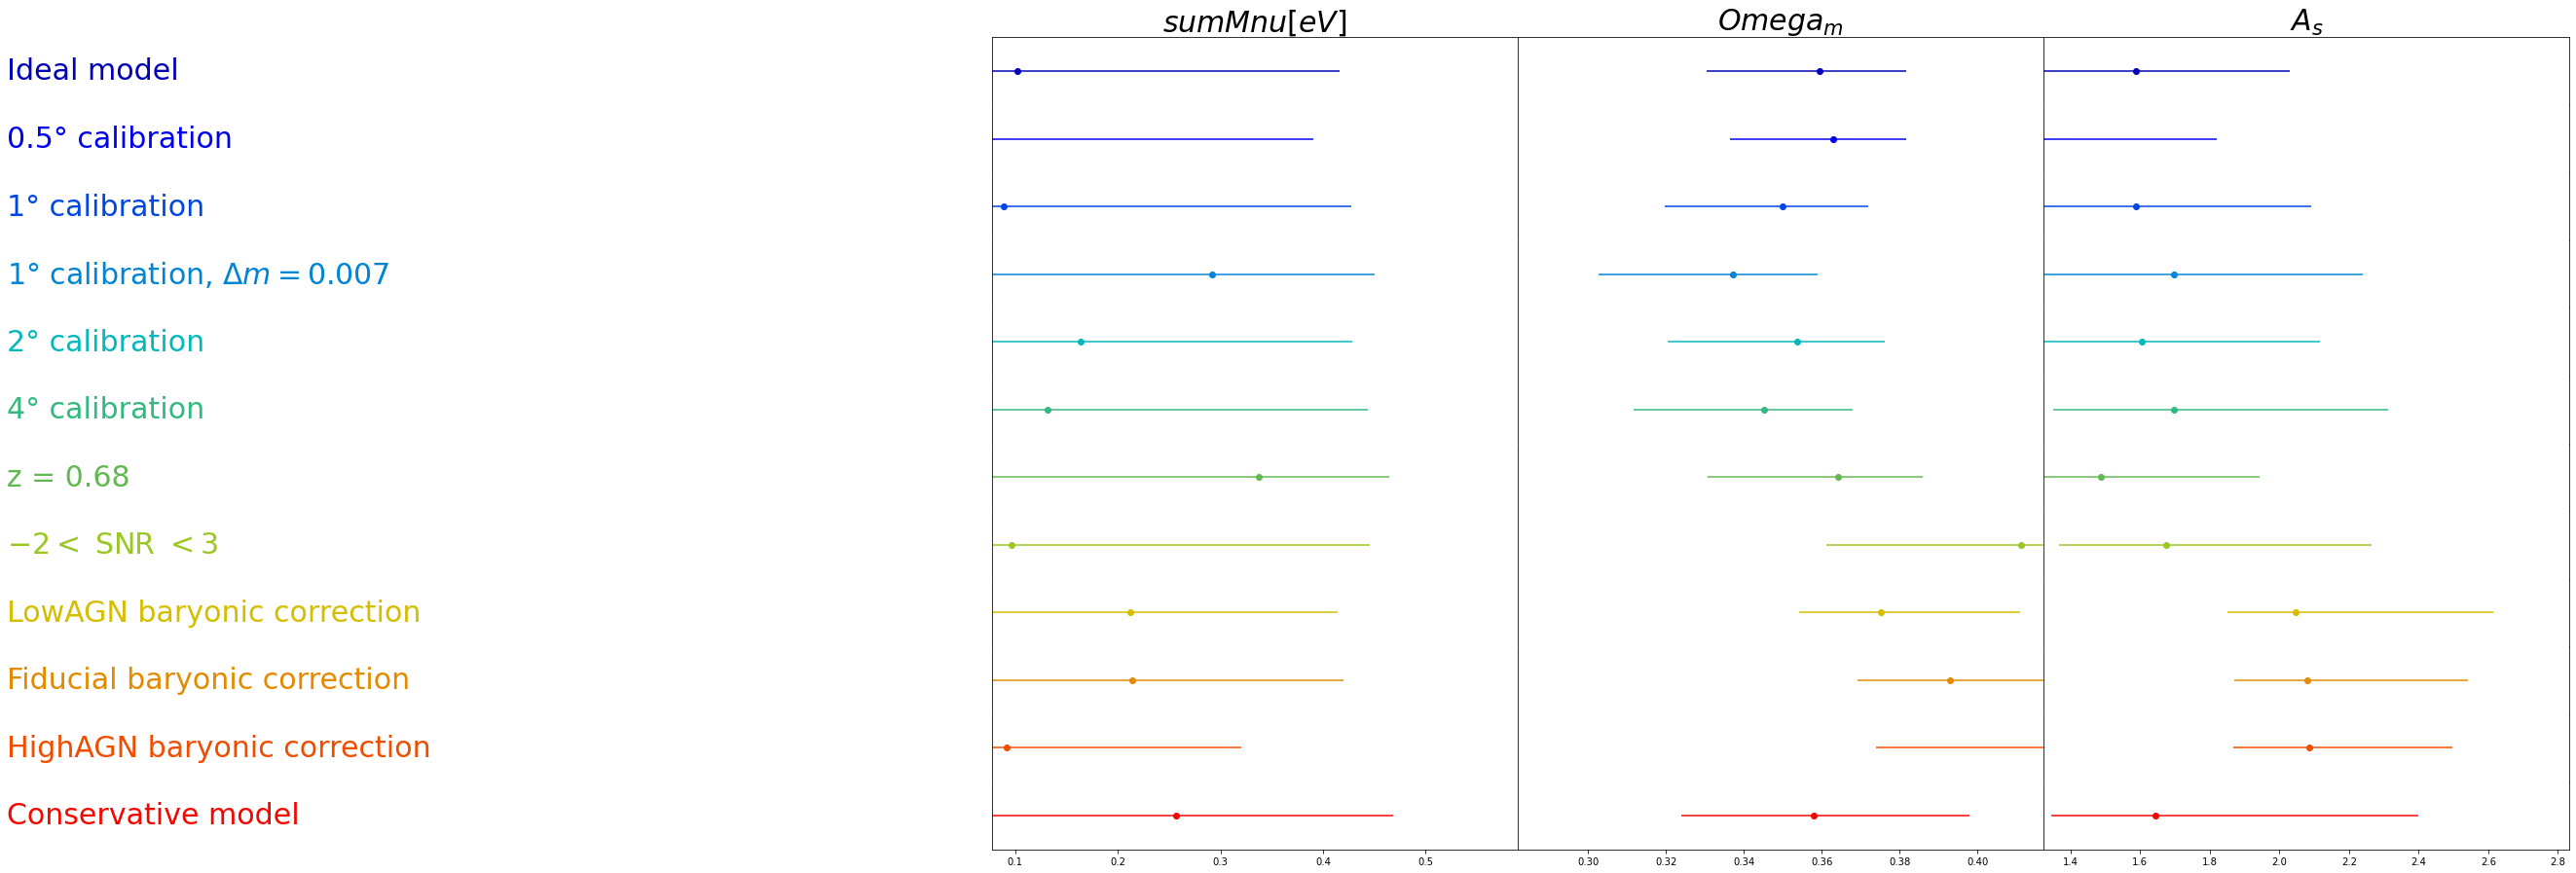

In [104]:
c = get_instance()
c.configure(legend_color_text=True,legend_kwargs={"fontsize": 35},tick_font_size=30, label_font_size=30,cmap='jet')
c.configure_truth(ls=":", color="#FB8C00")
fig = c.plotter.plot_summary(errorbar=True,filename='.././plot/resume.pdf',figsize=2)
fig.set_size_inches(5+fig.get_size_inches())  

# Test mass map (KiDS)

In [108]:
from astropy.io import fits

In [110]:
kids = fits.open('GalCatalog_KiDS1000_bin1_LOS1.fits')

In [111]:
kids.info()

Filename: GalCatalog_KiDS1000_bin1_LOS1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   (1089,)   uint8   
  1  /home/jharno/Projects/cosmoSLICS/00_a/GalCat/KiDS1000/GalCatalog....    1 BinTableHDU     36   221898R x 8C   [E, E, E, E, E, E, E, E]   


In [112]:
kd = kids[0].data
kids[1].data.shape

(221898,)

In [113]:
kd.dtype.name

'uint8'

In [114]:
from lenspack.utils import bin2d
from lenspack.image.inversion import ks93
from lenspack.peaks import find_peaks2d

npix = 128
resolution = 10*60 / npix
pixel_size = np.pi * resolution / 180. / 60. #rad/pixel

cat_data_array = fits.open('GalCatalog_KiDS1000_bin1_LOS1.fits')
x_arcmin = cat_data_array[1].data['x_arcmin'] 
y_arcmin = cat_data_array[1].data['y_arcmin'] 
eps1 = cat_data_array[1].data['eps_obs1']
eps2 = cat_data_array[1].data['eps_obs2']    

g1,g2=bin2d(x_arcmin,y_arcmin, v=(eps1,eps2), npix=npix)

kappa_map_KS_Emode, kappa_map_KS_Bmode = ks93(g1, g2)

In [115]:
x, y, h = find_peaks2d(kappa_map_KS_Emode, threshold=0.03, include_border=True)

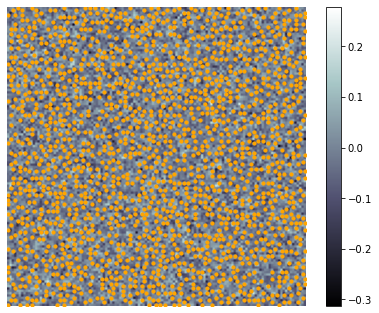

In [116]:
# Plot peak positions over the convergence
fig, ax = plt.subplots(1, 1, figsize=(7, 5.5))
mappable = ax.imshow(kappa_map_KS_Emode, origin='lower', cmap='bone')
ax.scatter(y, x, s=10, c='orange')  # reverse x and y due to array indexing
ax.set_axis_off()
fig.colorbar(mappable)
plt.show()